# What do I want?

- Match COSMOS galaxies to HSC objects 
- Remove non-matched HSC objects
- Create a classification based on COSMOS features
    - (z < 0.15) and (M_stellar < 1e9 M_sun)
- Use that COSMOS classification to create an HSC training set
- Run Random Forest & Logistic Regression on that data set (pure HSC colors/fluxes! no COSMOS features)
- Create confusion matrix
    - in particular, we're interested in the completeness after the inferred cut

## Next step?
In `classifier_ROC_curves.ipynb` I explore these results in more depth, looking at how each algorithm (Random Forest and Logistic Regression) fare as a function of the probability cut.

# Code

In [1]:
# give access to importing dwarfz
import os, sys
dwarfz_package_dir = os.getcwd().split("dwarfz")[0]
if dwarfz_package_dir not in sys.path:
    sys.path.insert(0, dwarfz_package_dir)

import dwarfz
    
# back to regular import statements

%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns
sns.set(context="poster", style="ticks", font_scale=1.4)

import numpy as np
import pandas as pd

In [2]:
COSMOS_filename = os.path.join(dwarfz.data_dir_default, "COSMOS_reference.sqlite")
COSMOS = dwarfz.datasets.COSMOS(COSMOS_filename)

In [3]:
HSC_filename = os.path.join(dwarfz.data_dir_default, "HSC_COSMOS_median_forced.sqlite3")
HSC = dwarfz.datasets.HSC(HSC_filename)

In [4]:
COSMOS.df.shape

(518331, 13)

In [5]:
HSC.df.shape

(928534, 20)

In [6]:
matches_filename = os.path.join(dwarfz.data_dir_default, "matches.sqlite3")
matches_df = dwarfz.matching.Matches.load_from_filename(matches_filename)

In [7]:
# build a DataFrame only of the successful matches
combined = matches_df[matches_df.match].copy()

# augment it with useful features and target columns
combined["ra"]       = COSMOS.df.loc[combined.index].ra
combined["dec"]      = COSMOS.df.loc[combined.index].dec
combined["photo_z"]  = COSMOS.df.loc[combined.index].photo_z
combined["log_mass"] = COSMOS.df.loc[combined.index].mass_med

photometry_cols = [
    "gcmodel_flux","gcmodel_flux_err","gcmodel_flux_flags",
    "rcmodel_flux","rcmodel_flux_err","rcmodel_flux_flags",
    "icmodel_flux","icmodel_flux_err","icmodel_flux_flags",
    "zcmodel_flux","zcmodel_flux_err","zcmodel_flux_flags",
    "ycmodel_flux","ycmodel_flux_err","ycmodel_flux_flags",
]

for col in photometry_cols:
    combined[col] = HSC.df.loc[combined.catalog_2_ids][col].values

## Turn fluxes into rough colors
Yes, I know these aren't exactly the right colors since I'm not including zero-points, but that shouldn't affect the results.

(When I get a chance, I'll re-download the dataset so that it includes magnitudes not just fluxes)

In [8]:
combined["g_minus_r"] = -.4*np.log10(combined["gcmodel_flux"] / combined["rcmodel_flux"])
combined["r_minus_i"] = -.4*np.log10(combined["rcmodel_flux"] / combined["icmodel_flux"])
combined["i_minus_z"] = -.4*np.log10(combined["icmodel_flux"] / combined["zcmodel_flux"])
combined["z_minus_y"] = -.4*np.log10(combined["zcmodel_flux"] / combined["ycmodel_flux"])

/Users/egentry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/Users/egentry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/Users/egentry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/egentry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/Users/egentry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/Users/egentry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()
/Users/egentry/anaconda3/li

For now, filter out bad photometry. Later I could consider passing this into the classifier, as an imputed/sentinel value

In [9]:
mask =    np.isfinite(combined["g_minus_r"]) & np.isfinite(combined["r_minus_i"]) \
        & np.isfinite(combined["i_minus_z"]) & np.isfinite(combined["z_minus_y"]) \
        & np.isfinite(combined["icmodel_flux"]) \
        & (~combined.gcmodel_flux_flags) & (~combined.rcmodel_flux_flags) \
        & (~combined.icmodel_flux_flags) & (~combined.zcmodel_flux_flags) \
        & (~combined.ycmodel_flux_flags)

combined = combined[mask]

combined["log_icmodel_flux"] = np.log10(combined["icmodel_flux"])

# View distribution & cuts

These cuts define the population of galaxies we're trying to infer (low-z and low mass).

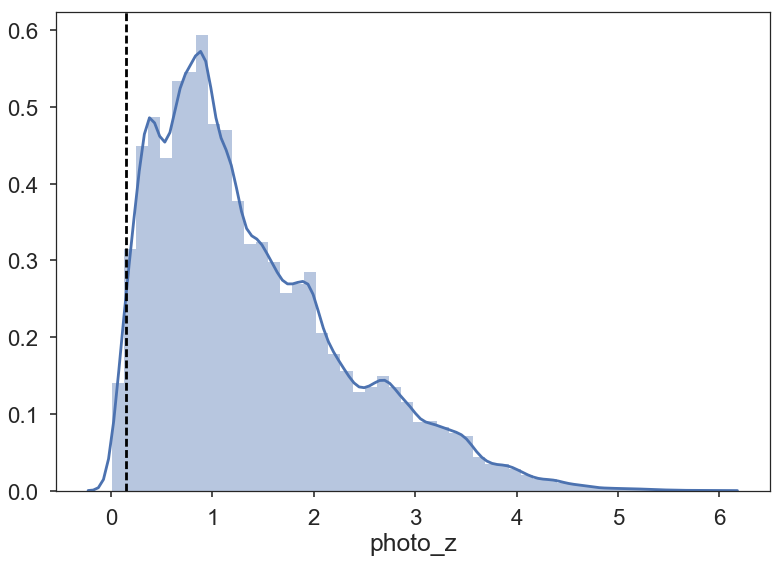

In [10]:
sns.distplot(combined.photo_z)
plt.axvline(.15, linestyle="dashed", color="k")

Let's see the redshift distribution for $z<0.3$

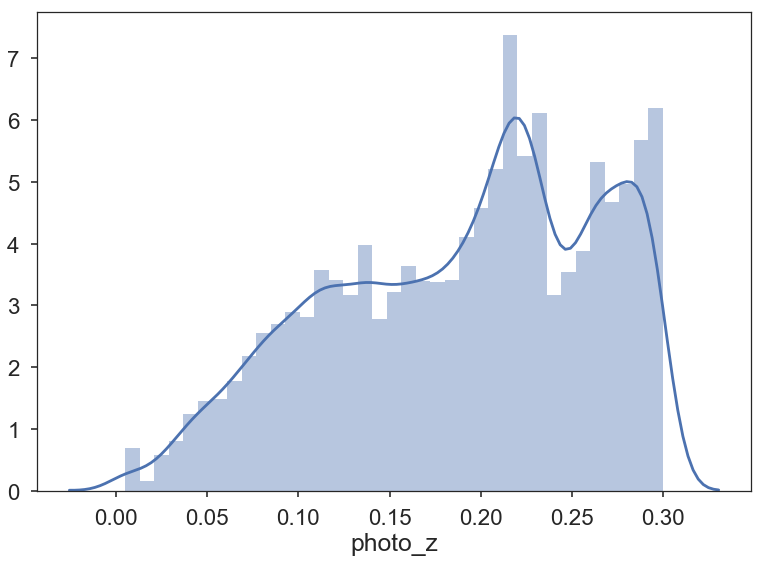

In [11]:
sns.distplot(combined.photo_z[combined.photo_z < .3])

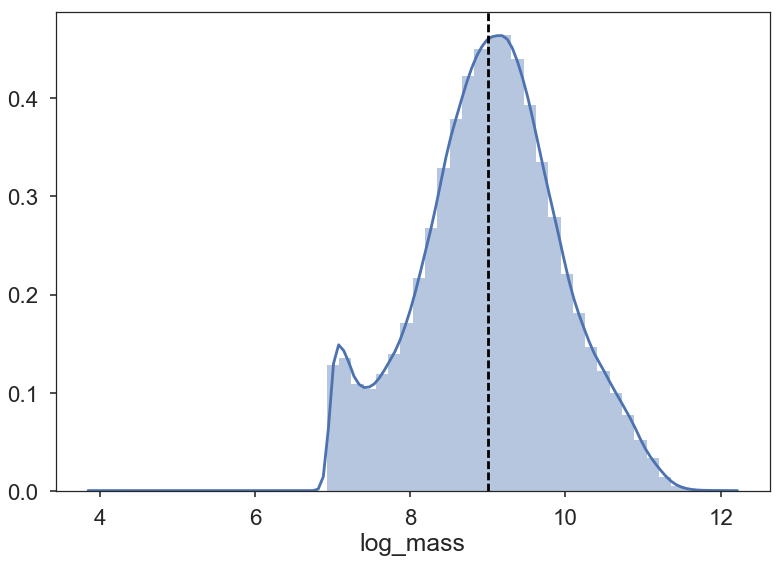

In [12]:
sns.distplot(combined.log_mass)

plt.axvline(9, linestyle="dashed", color="k")

# Create classification labels

Class A: matched **and** (low redshift + low mass)

Class B: matched **but not** (low redshift + low mass)

In [13]:
low_z    = (combined.photo_z  < .15)
low_mass = (combined.log_mass < 9)

In [14]:
class_a =  (low_z & low_mass)
class_b = ~(low_z & low_mass)

In [15]:
class_a.mean()

0.022124239582581931

In [16]:
class_b.mean()

0.97787576041741808

In [17]:
class_a.sum() / (class_a.sum() + class_b.sum())

0.022124239582581931

In [18]:
class_b.sum() / (class_a.sum() + class_b.sum())

0.97787576041741808

In [19]:
combined["low_z_low_mass"] = class_a
combined.head()

,catalog_2_ids,sep,match,error,ra,dec,photo_z,log_mass,gcmodel_flux,gcmodel_flux_err,...,zcmodel_flux_flags,ycmodel_flux,ycmodel_flux_err,ycmodel_flux_flags,g_minus_r,r_minus_i,i_minus_z,z_minus_y,log_icmodel_flux,low_z_low_mass
catalog_1_ids,,,,,,,,,,,,,,,,,,,,,
219656,43158447025298860,0.471546,True,False,150.388349,1.614538,2.3343,8.99275,5.800470e-31,2.102453e-31,...,False,4.328439e-31,1.392682e-30,False,0.144670,0.098257,-0.030754,-0.263026,-29.629218,False
219741,43158447025298862,0.202378,True,False,150.402935,1.614631,2.1991,9.71373,8.775548e-31,2.110055e-31,...,False,2.347631e-30,1.432457e-30,False,0.099205,0.012165,-0.071279,0.130851,-29.778300,False
219743,43158584464246387,0.207967,True,False,150.295083,1.614662,2.4407,9.77811,1.312252e-30,3.044583e-31,...,False,3.960493e-30,2.091224e-30,False,0.119917,0.073225,0.032795,-0.034045,-29.399128,False
219744,43158584464253383,0.295316,True,False,150.239919,1.614675,0.2079,7.04224,8.597155e-31,1.999684e-31,...,False,6.612980e-31,1.594763e-30,False,0.087705,-0.006288,0.078045,-0.205045,-29.862103,False
219769,43158584464277538,0.410593,True,False,150.180826,1.614706,1.2060,7.92008,1.152067e-30,1.891072e-31,...,False,1.530384e-30,1.368668e-30,False,-0.166723,-0.537628,0.716014,0.037666,-31.699399,False


# Build Classifier

In [20]:
features = combined.loc[:,["g_minus_r", "r_minus_i", "i_minus_z", "z_minus_y",
                              "log_icmodel_flux"]]

target = combined.loc[:,["low_z_low_mass"]]

In [21]:
target.mean()

low_z_low_mass    0.022124
dtype: float64

## Partition training and testing sets

In [22]:
testing_fraction = .1
test_set_indices = np.random.choice(target.index.values, 
                                    replace=False,
                                    size=int(testing_fraction*target.size)
                                   )

training_set_indices = np.array(list(set(target.index.values) - set(test_set_indices)))

features_train = features.loc[training_set_indices]
features_test  = features.loc[test_set_indices]

target_train   = target.loc[training_set_indices]
target_test    = target.loc[test_set_indices]

## Random Forest: train & test

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
classifier = RandomForestClassifier()
classifier = classifier.fit(features_train, target_train.values.flatten())

In [25]:
target_predicted_simple = classifier.predict(features_test)

In [26]:
target_prob = classifier.predict_proba(features_test)[:,1]
target_predicted = (target_prob > .01)

In [27]:
target_prob.min()

0.0

In [28]:
target_prob.max()

1.0

In [29]:
target_prob.mean()

0.023848682751030144

In [30]:
# When you use a symmetric loss function
# (i.e. weight false positive and false negatives equally)
target_predicted_simple.mean()

0.0031859577409756243

In [31]:
# When you use an asymmetric loss function
# (i.e. value completeness more than purity)
target_predicted.mean()

0.16395659883983049

In [32]:
# Actual values
target_test.values.flatten().mean()

0.021009287367376995

## Random Forest:  Create Confusion Matrix

In [33]:
target_predicted

array([False, False, False, ..., False, False,  True], dtype=bool)

In [34]:
true_a =  target_test.values.flatten()
true_b = ~target_test.values.flatten()

predicted_a =  target_predicted
predicted_b = ~target_predicted

In [35]:
true_a.size

33271

In [36]:
true_a.sum()

699

In [37]:
predicted_a.sum()

5455

In [38]:
(true_a & predicted_a).sum()

302

In [39]:
completeness = (true_a & predicted_a).sum() / (true_a).sum() 
completeness

0.43204577968526464

In [40]:
purity = (true_a & predicted_a).sum() / (predicted_a).sum() 
purity

0.055362053162236483

## Random Forest: Compare to overall fraction in training set

How does this RF method compare to subsampling randomly

In [41]:
true_a.size

33271

In [42]:
predicted_a.size

33271

In [43]:
print("Completeness with random sampling: ", predicted_a.sum() / predicted_a.size)
print("Completeness with smart  sampling: ", completeness)

Completeness with random sampling:  0.16395659884
Completeness with smart  sampling:  0.432045779685


In [44]:
print("Purity with random sampling: ", true_a.sum() / true_a.size)
print("Purity with smart sampling : ", purity)

Purity with random sampling:  0.0210092873674
Purity with smart sampling :  0.0553620531622


In [45]:
# by definition...
print("Sample size reduction with random sampling: ", (predicted_a.sum() / predicted_a.size)**-1)
print("Sample size reduction with smart sampling : ", (predicted_a.sum() / predicted_a.size)**-1)

Sample size reduction with random sampling:  6.09917506874
Sample size reduction with smart sampling :  6.09917506874


Okay, so our cut has improved purity by a factor of 2-3, relative to downsampling the catalog at random.

Unfortunately, our completeness isn't great: we're down to ~40%

# To do:
- Find a better algorithm?
 - We really aren't doing the type of classification that RandomForest is trying to optimize. It cares more about purity, but I'm more worried about completeness

## Logistic Regression: train & test

In [46]:
from sklearn.linear_model import LogisticRegression

In [47]:
classifier = LogisticRegression(class_weight="balanced")
classifier = classifier.fit(features_train, np.array(target_train.values.flatten(), dtype=int))

In [48]:
target_predicted_simple = classifier.predict(features_test)

In [49]:
target_prob

array([ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0.1])

In [50]:
target_prob = classifier.predict_proba(features_test)[:,1]
target_predicted = (target_prob > .577)

In [51]:
target_prob.min()

3.3925373395521233e-05

In [52]:
target_prob.max()

0.99361885155660623

In [53]:
# When you use a symmetric loss function
# (i.e. weight false positive and false negatives equally)
target_predicted_simple.mean()

0.38706380932343482

In [54]:
# When you use an asymmetric loss function
# (i.e. value completeness more than purity)
target_predicted.mean()

0.15965856151002375

In [55]:
# Actual values
target_test.values.flatten().mean()

0.021009287367376995

## Logistic Regression: Create Confusion Matrix

In [56]:
target_predicted

array([False, False, False, ..., False, False, False], dtype=bool)

In [57]:
true_a =  target_test.values.flatten()
true_b = ~target_test.values.flatten()

predicted_a =  target_predicted
predicted_b = ~target_predicted

In [58]:
true_a.size

33271

In [59]:
true_a.sum()

699

In [60]:
predicted_a.sum()

5312

In [61]:
(true_a & predicted_a).sum()

240

In [62]:
completeness = (true_a & predicted_a).sum() / (true_a).sum() 
completeness

0.34334763948497854

In [63]:
purity = (true_a & predicted_a).sum() / (predicted_a).sum() 
purity

0.045180722891566265

## Logistic Regression: Compare to overall fraction in training set

How does this RF method compare to subsampling randomly

In [64]:
true_a.size

33271

In [65]:
predicted_a.size

33271

In [66]:
print("Completeness with random sampling: ", predicted_a.sum() / predicted_a.size)
print("Completeness with smart  sampling: ", completeness)

Completeness with random sampling:  0.15965856151
Completeness with smart  sampling:  0.343347639485


In [67]:
print("Purity with random sampling: ", true_a.sum() / true_a.size)
print("Purity with smart sampling : ", purity)

Purity with random sampling:  0.0210092873674
Purity with smart sampling :  0.0451807228916


In [68]:
# by definition...
print("Sample size reduction with random sampling: ", (predicted_a.sum() / predicted_a.size)**-1)
print("Sample size reduction with smart sampling : ", (predicted_a.sum() / predicted_a.size)**-1)

Sample size reduction with random sampling:  6.26336596386
Sample size reduction with smart sampling :  6.26336596386
